# Описание проекта
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

# Цель исследования

1. Определить, какая доля пользователей пользуется подпиской
2. Выяснить, насколько больше люди с подпиской пользуются сервисом и как это отражается на износе техники
3. Рассчитать помесячную выручку от пользователей с подпиской и без и выяснить, кто приносит больше денег

# Ход работы
Нам даны три датасета: `users_go.csv`, `rides_go.csv` и `subscriptions_go.csv`, содержащих данные о пользователях, их поездках и подписках соответственно. О качестве данных ничего неизвестно, поэтому сначала мы проверим наличие в них пропусков, дубликатов. 

Проверив данные на эти аномалии, постараемся исправить их, выяснить влияние ошибок и исправлений на результаты.

Далее приступим  к исследовательскому анализу данных. Для анализа также будет необходимо объединить эти три датафрейма в один, а после этого сделать необходимые срезы уже из объединенного датафрейма. 

Итого, в нашем исследовании можно выделить следующие шаги:
- загрузка и обзор данных
- предобработка данных
- расчеты и добавление необходимых элементов к исходным датасетам
- объединение данных
- получение необходимых срезов и расчеты по ним
- анализ статистических гипотез и формулировка выводов
- формовка общего вывода и предложений по улучшению сервиса

# Описание данных
В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи** — **`users_go.csv`**

- **`user_id`**	уникальный идентификатор пользователя
- **`name`**	имя пользователя
- **`age`**	возраст
- **`city`**	город
- **`subscription_type`**	тип подписки (free, ultra)

**Поездки** — **`rides_go.csv`**

- **`user_id`**	уникальный идентификатор пользователя
- **`distance`**	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- **`duration`**	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- **`date`**	дата совершения поездки

**Подписки** — **`subscriptions_go.csv`**

- **`subscription_type`**	тип подписки
- **`minute_price`**	стоимость одной минуты поездки по данной подписке
- **`start_ride_price`**	стоимость начала поездки
- **`subscription_fee`**	стоимость ежемесячного платежа

import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns
import numpy as np
from math import factorial, sqrt

## Шаг 1. Загрузка данных
### Считайте CSV-файлы с данными с помощью библиотеки Pandas и сохраните их в датафреймы. Пути к файлам:
- `/datasets/users_go.csv`
- `/datasets/rides_go.csv`
- `/datasets/subscriptions_go.csv`

Считываем данные и сохраняем с переменные `users`, `rides` и `subscriptions` соответственно

In [1]:
import pandas as pd
import seaborn as sns
from math import factorial, sqrt
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np

users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

### Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

Выводим по пять первых строк каждого датафрейма и саруз после вывда - общую информацию о них.

#### Пользователи

In [2]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Видим, что у нас в датафрейме с пользователями 5 столбцов:
- **`user_id`**	уникальный идентификатор пользователя
- **`name`**	имя пользователя
- **`age`**	возраст
- **`city`**	город
- **`subscription_type`**	тип подписки (free, ultra)

В каждом из них по 1565 ненулевых значений.

Уникальный идентификатор пользователя и возраст - целочисленный тип, все остальные - строковый.

#### Поездки

In [4]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В датафрейме с поездками у нас 4 столбца:
- **`user_id`**	уникальный идентификатор пользователя
- **`distance`**	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- **`duration`**	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- **`date`**	дата совершения поездки

В каждом из них 18068 ненулевых значений. 

Уникальный идентификатор пользователя - целочисленное значение, дистанция и продолжительность - вещественные, а дата - строковый типы (запоминаем про дату, её тип точно надо поменять на тип `DateTime`)

#### Подписки

In [6]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В датафрейме с подписками у нас 4 колонки:
- **`subscription_type`**	тип подписки
- **`minute_price`**	стоимость одной минуты поездки по данной подписке
- **`start_ride_price`**	стоимость начала поездки
- **`subscription_fee`**	стоимость ежемесячного платежа

В каждой из них по 2 ненулевых значения, тип подписки - строковый тип, остальные - целочисленный.

### **Промежуточный итог №1**
Мы рассмотрели каждый из датафреймов, присвоили их переменным. Рассмотрели информацию о каждом из них, выяснили, что пропусков в данных нет, есть несостыковки с типами переменных, будем решать их на следующем этапе.

## Шаг 2. Предобработка данных

### Приведите столбец date к типу даты Pandas.

Видим, что столбец `date` представляет собой строковый тип данных, надо привести его к типу даты Pandas

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Как видим на представленной информации о датафрейме поездок, тип даты был успешно изменён на требуемый

### Создайте новый столбец с номером месяца на основе столбца date.

Теперь необходимо на основании столбца даты создать столбец с номером месяца в этом же датафрейме. После добавления выведем шапку датафрейма на экран

In [9]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Как видим, мы успешно добавили новый столбец с номером месяца на основании стобца с датой.

Проверим также, к какому году/каким годам у нас относятся наши данные:

In [10]:
pd.DatetimeIndex(rides['date']).year.value_counts()

2021    18068
Name: date, dtype: int64

Видим, что все данные у нас за 2021 год, аномалий не обнаружено

### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

Теперь необходимо проверить наличие пропусков и дубликатов в каждом датафрейме

#### Пользователи
##### Пропуски
Рассмотрим датафрейм с пользователями: есть ли в нём пропуски

In [11]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропусков нет

##### Дубликаты
Проверим наличие явных и неявных дубликатов. Сначала явные:

In [12]:
users.duplicated().sum()

31

Явные дубликаты в наличии, удаляем их c обновлением индексов и проверяем, удалились ли

In [13]:
users = users.drop_duplicates().reset_index(drop = True)
users.duplicated().sum()

0

Проверяем, есть ли неявные дубликаты, смотрим на город

In [14]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

С городами все чисто, смотрим на тип подписки

In [15]:
users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

Тоже порядок. Наконец, взглянем на имена

In [16]:
print(sorted(users['name'].unique()), sep = '')

['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра', 'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина', 'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий', 'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина', 'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём', 'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия', 'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника', 'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад', 'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод', 'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей', 'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила', 'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий', 'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена', 'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар', 'Злата', 'Иван', 'Игнат', 'Игорь', 'Ильдар', 'Илья', 'Инна', 'Ирина', 'Камилла', 'Карина', 'Каролина', 'Кира', 'К

Видим, что вроде с именами все хорошо, только смущает немного момент с именами `Наталья`, `Наталия` и `Наташа`. Проверим, не совпадает ли между ними хоть один id пользователя

In [17]:
wrong_ids = []
for id_1 in users.query('name == "Наташа"')['user_id']:
    for id_2 in users.query('name == "Наталья"')['user_id']:
        if id_1 == id_2:    
            wrong_ids.append(id_1)

for id_1 in users.query('name == "Наташа"')['user_id']:
    for id_2 in users.query('name == "Наталия"')['user_id']:
        if id_1 == id_2:    
            wrong_ids.append(id_1)
if len(wrong_ids) ==0:
    print('id пользователей с такими именами не совпадают, можно не считать их за неявные дупликаты')
else:
    print('id пользователей с такими именами совпадают,- это неявные дупликаты')

id пользователей с такими именами не совпадают, можно не считать их за неявные дупликаты


Видим, что с именами `Наталья`, `Наталия` и `Наташа` все благополучно разрешилось.

Посмотрим на количество уникальных id пользователей и выведем их на экран:

In [18]:
users['user_id'].nunique()

1534

Проверим, есть ли в нем какие-либо выбросы по уникальным id. Мы знаем, что они идут по порядку, поэтому циклом сравним список номеров от 1 до 1534 с отсортированным списком уникальных номеров id пользователей.

In [19]:
wrong_ids_positions = [] # создаем список, в который будем добавлять позиции неправильных id
for i in range(users.shape[0]): 
    if sorted(users['user_id'].unique())[i] != (i+1): # если id пользователя не соответствует тому, 
                                                      # что должен идти по порядку (счетчик на это)
        wrong_ids_positions.append(i) # добавляем его позицию в списке в список с неправильными
if len(wrong_ids_positions) == 0: # проверяем, есть ли у нас  неправильные номера
    print('Номера id пользователей записаны верно!') 
else: # если они есть, тогда выводим их на экран для ознакомления
    for i in range(len(wrong_ids_positions)):
        wrong_id = sorted(users['user_id'].unique())[wrong_ids_positions[i]]
        print(f'Проверить номер пользователя {wrong_id}')

Номера id пользователей записаны верно!


Видим, что неправильных номеров нет

Выведем информацию об этом датафрейме на экран, чтобы проверить, не резанули ли мы лишнего

In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


Все в порядке, сначала было 1565 строк, убрали 31 дубликат, соответственно, осталось 1534 строки

#### Поездки
##### Пропуски
Рассмотрим датафрейм поездок на наличие пропусков

In [21]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Пропусков нет

##### Дубликаты
Проверим, есть ли в нем явные и неявные дубликаты

In [22]:
rides.duplicated().sum()

0

Неявных дубликатов не выявлено. А что по явным? Посмотрим на количество уникальных id пользователей

In [23]:
rides['user_id'].nunique()

1534

Оно совпадает с теми, что в датафрейме пользователей, проверим, есть ли несовпадения

In [24]:
blowout = [] # создаем список с выбросами
for i in range(len(rides['user_id'].unique())):
    if sorted(rides['user_id'].unique())[i] != sorted(users['user_id'].unique())[i]:
        blowout.append(i)
if len(blowout) == 0: # проверяем, есть ли у нас  несовпадения
    print('Несовпадений между датафреймами пользователей и поездок по уникальным id пользователей нет') 
else: # если они есть, тогда выводим их на экран для ознакомления
    for i in range(len(blowout)):
        wrong_id = sorted(rides['user_id'].unique())[blowout[i]]
        print(f'Проверить номер пользователя {wrong_id}')

Несовпадений между датафреймами пользователей и поездок по уникальным id пользователей нет


#### Подписки
##### Пропуски
Проверим наличие пропусков в подписках

In [25]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков нет

##### Дубликаты
Проверим наличие явных и неявных дубликатов (датафрейм состоит всего из двух строк, поэтому ограничимся визуальной проверкой)

In [26]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Дубликатов нет

### **Промежуточный итог №2**
Мы проверили каждый датафрейм на наличие пропусков и дубликатов, пропусков ни в одном из них не было.
В датафрейме пользователей удалили явные дубликаты, также проверили, есть ли неявные (`Наталья`, `Наталия` и `Наташа`), выяснилось, что нет, больше неявных дупликатов в этом датафрейме не было обнаружено. Проверили, есть ли аномалии с годом, к которому относятся данные, - все хороши, данные у нас за 2021 год.
Проверили правильность записи уникальных id пользователей, городов, с ними все было в порядке.
В датафрейме поездок также проверили id пользователей, а также сравнили с id пользователей датафрейма пользователей, несовпадений не выявлено.
В датафрейме подписок не было ни пропусков, ни дубликатов.

## Шаг 3. Исследовательский анализ данных
Опишите и визуализируйте общую информацию о пользователях и поездках:

### Частота встречаемости городов
Выведем на экран частоту встречаемости городов и построим наглядный барплот

In [27]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

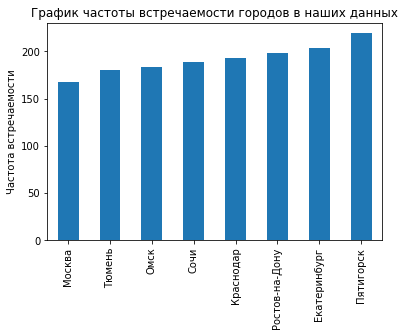

In [28]:
users['city'].value_counts(ascending = True).plot.bar()
plt.ylabel('Частота встречаемости')
plt.title('График частоты встречаемости городов в наших данных')
plt.show()

Видим, что чаще всего встречается Пятигорск, реже всего Москва

### Соотношение пользователей с подпиской и без подписки
Выведем на соотношение пользователей с подпиской и без, сначала рассчитав и пересчитав на проценты

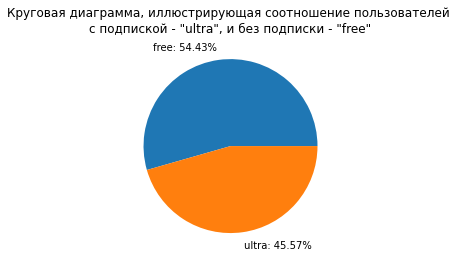

In [29]:
values = users['subscription_type'].value_counts()/users.shape[0]  # считаем долю каждой подписки
values = round(values*100, 2)  # переводим в более удобный вид с процентами и двумя знаками после запятой
names = []  # задаем пустой список подписей для круговой диагнаммы
for i in range(values.shape[0]):
    names.append(values.index[i] + ': ' + str(values[i]) + '%') # формируем подпись круговой диаграммы как: 
                                                                # название подписки: процент пользователей с такой подпиской
plt.pie(values, labels=names, labeldistance=1.15)  # строим круговую диаграмму
plt.title('Круговая диаграмма, иллюстрирующая соотношение пользователей \nс подпиской - "ultra", и без подписки - "free"')
plt.show()

Видим, что пользователей без подписки у нас больше: 54.43%, против 44.57% пользователей с подпиской

### Возраст пользователей
Выведем барплот по возрасту пользователей

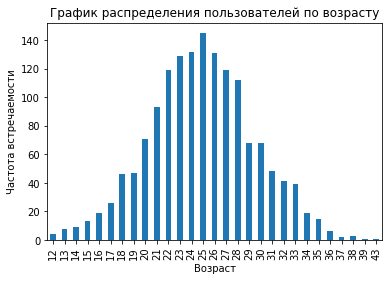

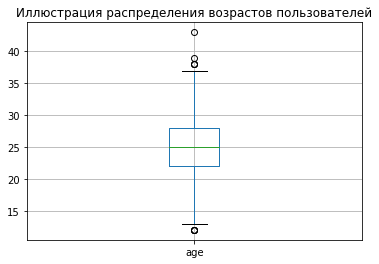

In [30]:
users.groupby('age')['age'].count().plot.bar()
plt.ylabel('Частота встречаемости')
plt.xlabel('Возраст')
plt.title('График распределения пользователей по возрасту')
plt.show()

users.boxplot('age')
plt.title('Иллюстрация распределения возрастов пользователей')
plt.show()

На гистограмме видим, что пользователи по возрасту распределены практически нормально, больше всего людей возрастом от 20 до 30 лет.

На ящике с усами четко видно, что медиана возрастов приходится на 25 лет, нижний квартиль - примерно 22 года, верхний - около 28 лет. Также видим, что есть выбросы, соответствующие возрасту либо старше 37 лет, либо моложе 13.

### Расстояние, которое пользователь преодолел за одну поездку
Выведем гистограмму по расстоянию, которое пользователь преодолел за одну поездку

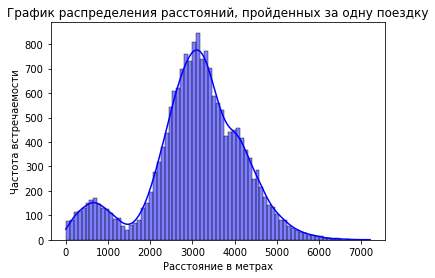

In [31]:
sns.histplot(data=rides, x="distance", color="blue", kde=True)

plt.ylabel('Частота встречаемости')
plt.xlabel('Расстояние в метрах')
plt.title('График распределения расстояний, пройденных за одну поездку')
plt.show()

Видим, что максимум по расстояниям приходится на 3000 метров, но есть и небольшой пичок в начале, где-то на 1000 метрах

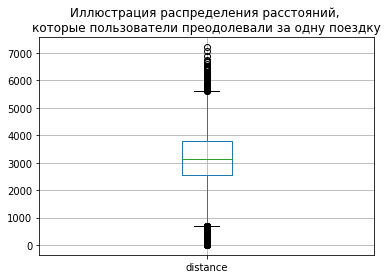

In [32]:
rides.boxplot('distance')
plt.title('Иллюстрация распределения расстояний, \nкоторые пользователи преодолевали за одну поездку')
plt.show()

Видим, что медиана находится около 3000 метров, нижний квартиль - около 2600, верхний - около 3900. Также видим выбросы, соответствующим расстояниям меньше 800 или больше 5600 метров.

### Продолжительность поездок
Выведем гистограмму по продолжительности поездок

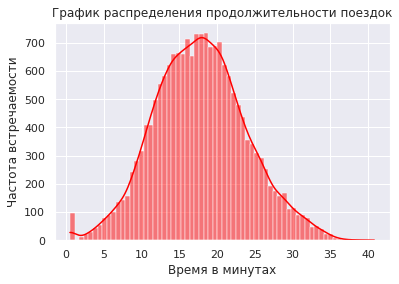

In [33]:
sns.set(style="darkgrid")

sns.histplot(data=rides, x="duration", color="red", kde=True)

plt.ylabel('Частота встречаемости')
plt.xlabel('Время в минутах')
plt.title('График распределения продолжительности поездок')
plt.show()

В целом, распределение по продолжительности поездок распределено нормально, максимум приходится на 17-18 минут, большинство пользователей укладывается в 10-25 минут

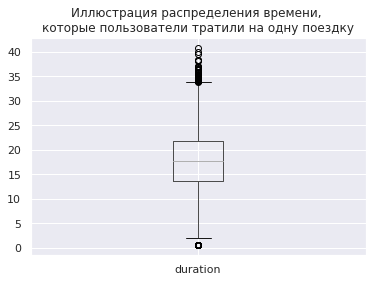

In [34]:
rides.boxplot('duration')
plt.title('Иллюстрация распределения времени, \nкоторые пользователи тратили на одну поездку')
plt.show()

Видим, что медиана около 18 минут, нижний квартиль в районе 14 минут, верхний - 22 минуты. Также видим выбросы, соответствующие времени, которое либо меньше 2 минут, либо больше 34.

### **Промежуточный итог №3**

Мы рассмотрели следующие данные:
- **`частота встречаемости городов`**
        чаще всего встречается Пятигорск, реже всего Москва
- **`соотношение пользователей с подпиской и без подписки`**
        пользователей без подписки у нас больше: 54.43%, против 44.57% пользователей с подпиской
- **`возраст пользователей`**
        На гистограмме видим, что пользователи по возрасту распределены практически нормально, больше всего людей возрастом от 20 до 30 лет.
        На боксплоте четко видно, что медиана возрастов приходится на 25 лет, нижний квартиль - примерно 22 года, верхний - около 28 лет. Также видим, что есть выбросы, соответствующие возрасту либо старше 37 лет, либо моложе 13.
        
- **`расстояние, которое пользователь преодолел за одну поездку`**
        максимум по расстояниям приходится на 3000 метров, но есть и небольшой пичок в начале, где-то на 1000 метрах
        На боксплоте видим, что медиана находится около 3000 метров, нижний квартиль - около 2600, верхний - около 3900. Также видим выбросы, соответствующим расстояниям меньше 800 или больше 5600 метров.
- **`продолжительность поездок`**
        В целом, распределение по продолжительности поездок распределено нормально, максимум приходится на 17-18 минут, большинство пользователей укладывается в 10-25 минут
        На боксплоте видим, что медиана около 18 минут, нижний квартиль в районе 14 минут, верхний - 22 минуты. Также видим выбросы, соответствующие времени, которое либо меньше 2 минут, либо больше 34.

## Шаг 4. Объединение данных

### Объедините данные о пользователях, поездках и подписках в один датафрейм
Для этого воспользуйтесь методом `merge()`.

Сначала объединим пользователей и поездки. Заметим, что у них есть общий столбец - `user_id`. По нему и будем объединять:

In [35]:
users_rides = users.merge(rides, on = 'user_id', how = 'right')

Выведем первые пять строк получившегося датафрейма и информацию о нём

In [36]:
users_rides.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [37]:
users_rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


Прекрасно, первый этап прошёл без проблем, теперь объединим получившийся датафрейм пользователей и поездок с датафреймом подписок. Заметим, что теперь общие столбец - `subscription_type`,- по нему и объединяем

In [38]:
users_rides_subs = users_rides.merge(subscriptions, on = 'subscription_type', how = 'left')

Выведем первые пять строк получившегося датафрейма и информацию о нём

In [39]:
users_rides_subs.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [40]:
users_rides_subs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Мы сформировали объединенный датафрейм пользователей с их поездками и подписками!

### Создайте ещё два датафрейма из датафрейма, созданного на предыдущем этапе
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

В каждом обновляем индексы

In [41]:
# датафрейм пользователей без подписки
no_sub_users = users_rides_subs.query('subscription_type == "free"').reset_index(drop=True)

# датафрейм пользователей c подпиской
sub_users = users_rides_subs.query('~(subscription_type == "free")').reset_index(drop=True)

Выведем каждый из них на экран:

In [42]:
no_sub_users.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [43]:
sub_users.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Мы получили два датафрейма для пользователей с и без подписки из исходного

### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

#### Расстояние и время поездок для пользователей с подпиской

Расстояние для пользователей с подпиской:

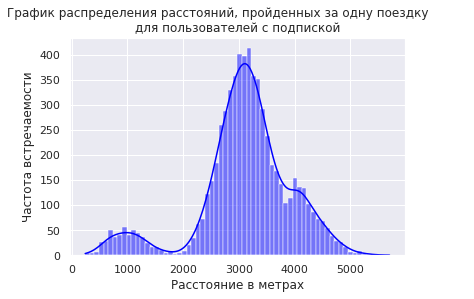

In [44]:
sns.set(style="darkgrid")

sns.histplot(data=sub_users, x="distance", color="blue", kde=True)

plt.ylabel('Частота встречаемости')
plt.xlabel('Расстояние в метрах')
plt.title('График распределения расстояний, пройденных за одну поездку\
          \nдля пользователей с подпиской')
plt.show()

Видим четкий пик на 3000 метрах, а также присутствует пичок на 1000 метрах

Время для пользователей с подпиской

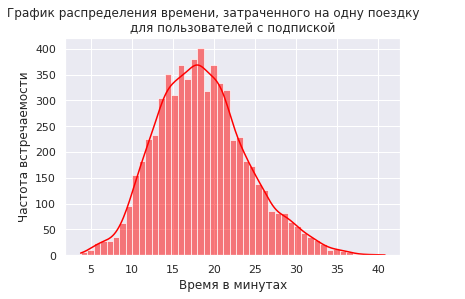

In [45]:
sns.set(style="darkgrid")

sns.histplot(data=sub_users, x="duration", color="red", kde=True)

plt.ylabel('Частота встречаемости')
plt.xlabel('Время в минутах')
plt.title('График распределения времени, затраченного на одну поездку\
          \nдля пользователей с подпиской')
plt.show()

Большинство тратит на поездку от 10 до 25 минут

#### Расстояние и время поездок для пользователей без подписки

Расстояние для пользователей без подписки

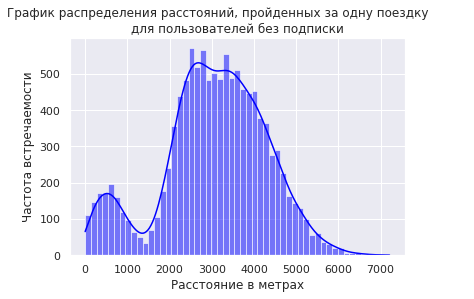

In [46]:
sns.set(style="darkgrid")

sns.histplot(data=no_sub_users, x="distance", color="blue", kde=True)

plt.ylabel('Частота встречаемости')
plt.xlabel('Расстояние в метрах')
plt.title('График распределения расстояний, пройденных за одну поездку\
          \nдля пользователей без подписки')
plt.show()

Видим плато на максимуме поездок от 2500 до 4000 метров, также видим более выраженный, чем у пользователей с подпиской, пик на примерно 500 метрах. Судя по такой разнице, можно предположить, что подписка дает более продолжительную короткую поездку с бонусом или скидкой или чем-то около того. Без подписки это расстояние раза в два меньше

Время для пользователей без подписки

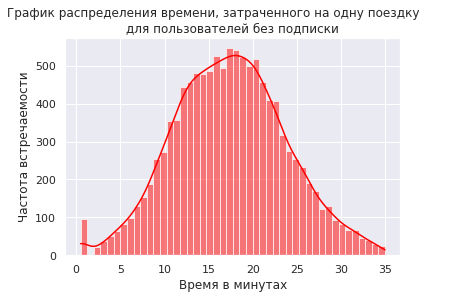

In [47]:
sns.set(style="darkgrid")

sns.histplot(data=no_sub_users, x="duration", color="red", kde=True)

plt.ylabel('Частота встречаемости')
plt.xlabel('Время в минутах')
plt.title('График распределения времени, затраченного на одну поездку\
          \nдля пользователей без подписки')
plt.show()

Видим, что большинство пользователей укладываются в те же 10-25 минут, что и пользователи с подпиской

Попробуем построить по два графика для расстояния и времени для этих пользователей рядом, чтобы оценить разницу визуально: 

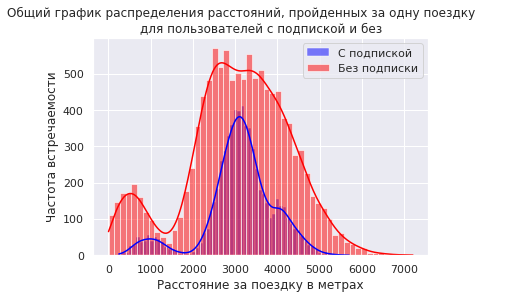

In [48]:
sns.histplot(data=sub_users, x="distance", color="blue", label="С подпиской", kde=True)
sns.histplot(data=no_sub_users, x="distance", color="red", label="Без подписки", kde=True)

plt.ylabel('Частота встречаемости')
plt.xlabel('Расстояние за поездку в метрах')
plt.legend() 
plt.title('Общий график распределения расстояний, пройденных за одну поездку\
          \nдля пользователей с подпиской и без')
plt.show()

Видим это смещение маленького пика для пользователей с подпиской и без. Для пользователей без подписки его максимум приходится на меньшее расстояние, чем для пользователей с подпиской. Также четко видно разницу в форме распределений для расстояний между пользователями с подпиской и без - у пользователей без подписки более в зоне максимума плато от 2 до 4 тысяч метров, в то время как у пользователей с подпиской виден ярко выраженный пик на 3000 метрах. После 3 тысяч метров у пользователей без подписки идёт плавное снижение в ноль к 7 тысячам метров, в то время как у пользователей с подпиской идет снижение до примерно трети от максимума к 4 тысячам метров, небольшое замедение падения с пологостью до 4300 метров, и затем падение в ноль к 5500 метров.

Видно, что распределение по расстояниям у пользователей без подписки шире (вполне логично, что без подписки особо бонусов или скидок нет, поэтому и пользоваться самокатами они будут для более длительных целей, не просто так покататься).

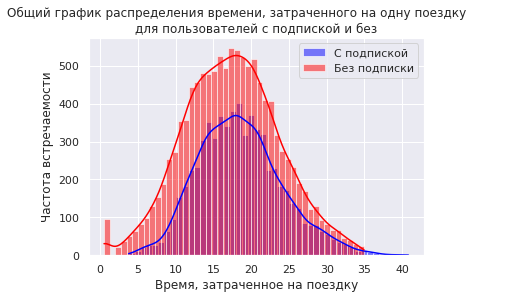

In [49]:
sns.histplot(data=sub_users, x="duration", color="blue", label="С подпиской", kde=True)
sns.histplot(data=no_sub_users, x="duration", color="red", label="Без подписки", kde=True)

plt.ylabel('Частота встречаемости')
plt.xlabel('Время, затраченное на поездку')
plt.title('Общий график распределения времени, затраченного на одну поездку\
          \nдля пользователей с подпиской и без')
plt.legend() 
plt.show()

Время поездки распределно примерно одинаково, только пользователи с подпиской смещены примерно на 5 минут вправо относительно пользователей без подписки

### **Промежуточный итог №4**

Мы проделали несколько действий:
- объединили данные о пользователях, поездках и подписках в один датафрейм (пользователей и поездки по id пользователей, получившийся датафрейм объединили с подписками по типу подписки)
- добавили два новых датафрейма из объединенного, в один включили пользователей с подпиской, в другой - без подписки
- провели визуализацию данных по расстоянию и длительности поездки для пользователей с подпиской и без неё
    - **Растояния** распределены по-разному:        
        Для пользователей `с подпиской`. Видим четкий пик на 3000 метрах, а также присутствует пичок на 1000 метрах.         
        Пользователи `без подписки`. Видим плато на максимуме поездок от 2500 до 4000 метров, также видим более выраженный, чем у пользователей с подпиской, пик на примерно 500 метрах. Судя по такой разнице, можно предположить, что подписка дает более продолжительную короткую поездку с бонусом или скидкой или чем-то около того. Без подписки это расстояние раза в два меньше.     
        Если сравнивать на одном графике: видим это смещение маленького пика для пользователей с подпиской и без. Для пользователей без подписки его максимум приходится на меньшее расстояние, чем для пользователей с подпиской. Также четко видно разницу в форме распределений для расстояний между пользователями с подпиской и без - у пользователей без подписки более в зоне максимума плато от 2 до 4 тысяч метров, в то время как у пользователей с подпиской виден ярко выраженный пик на 3000 метрах. После 3 тысяч метров у пользователей без подписки идёт плавное снижение в ноль к 7 тысячам метров, в то время как у пользователей с подпиской идет снижение до примерно трети от максимума к 4 тысячам метров, небольшое замедение падения с пологостью до 4300 метров, и затем падение в ноль к 5500 метров. 
        Также видно, что распределение по расстояниям у пользователей без подписки шире (вполне логично, что без подписки особо бонусов или скидок нет, поэтому и пользоваться самокатами они будут для более длительных целей, не просто так покататься).        

    - **Время поездки** распределено очень похоже: большинство пользователей что с подпиской, что без неё укладываются в примерно 10-25 минут поездки, единственное, времена поездкок пользователей с подпиской смещены относительно пользователей без подписки на примерно 5 минут.

## Шаг 5. Подсчёт выручки

### Агрегация данных
Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

Сгруппируем данные по пользователям и месяцам и рассчитаем необходимые стобцы. После обсчета выведем первые десять строк на экран

Проверим объединенный датафрейм на наличие пропусков и дупликатов:

In [50]:
users_rides_subs.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [51]:
users_rides_subs.duplicated().sum()

0

Пропусков и дупликатов нет, строим сводную таблицу

In [52]:
sum_users = pd.pivot_table(users_rides_subs, 
                           index = ['user_id','month'], 
                           values = ['distance','duration','start_ride_price', 'minute_price', 'subscription_fee', 'subscription_type'], 
                           aggfunc = {"distance": [sum, len], "duration": sum,
                                      'minute_price':'first', 'subscription_fee':'first',
                                      'start_ride_price':'first', 'subscription_type':'first'})
sum_users = sum_users.rename(columns = {'sum':'per_month', 'len':'count'})
sum_users['duration'] = np.ceil(sum_users['duration'])
sum_users.head()

distance               duration minute_price start_ride_price  \
                 count    per_month per_month        first            first   
user_id month                                                                 
1       1          2.0  7027.511294      42.0            6                0   
        4          1.0   754.159807       7.0            6                0   
        8          2.0  6723.470560      45.0            6                0   
        10         2.0  5809.911100      32.0            6                0   
        11         3.0  7003.499363      54.0            6                0   

              subscription_fee subscription_type  
                         first             first  
user_id month                                     
1       1                  199             ultra  
        4                  199             ultra  
        8                  199             ultra  
        10                 199             ultra  
        11                 199             ultra

Проверим также сводную таблицу на наличие пропусков и дупликатов:

In [53]:
sum_users.isna().sum()

distance           count        0
                   per_month    0
duration           per_month    0
minute_price       first        0
start_ride_price   first        0
subscription_fee   first        0
subscription_type  first        0
dtype: int64

In [54]:
sum_users.duplicated().sum()

0

Ни пропусков, ни дупликатов не обнаружено, все супер

Мы провели агрегацию данных по уникальным id пользователей и месяцам, рассчитав суммарное расстояние за месяц, количество поездок и суммарное время каждого пользователя за месяц и добавили в агрегированный датафрейм

### Помесячная выручка
В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

In [55]:
sum_users['month_revenue'] = (sum_users['distance']['count'] * sum_users['start_ride_price']['first']) + \
(sum_users['duration']['per_month'] * sum_users['minute_price']['first']) + \
sum_users['subscription_fee']['first'] 
sum_users = sum_users[['distance', 'duration', 'month_revenue', 'subscription_type']]
sum_users = sum_users.rename(columns = {'first':''})
sum_users.head()

distance               duration month_revenue subscription_type
                 count    per_month per_month                                
user_id month                                                                
1       1          2.0  7027.511294      42.0         451.0             ultra
        4          1.0   754.159807       7.0         241.0             ultra
        8          2.0  6723.470560      45.0         469.0             ultra
        10         2.0  5809.911100      32.0         391.0             ultra
        11         3.0  7003.499363      54.0         523.0             ultra

На основании предыдущего шага мы рассчитали помесячную выручку для каждого пользователя и добавили в агрегированный датафрейм

### **Промежуточный итог №5**

Мы создали агрегированный датафрейм с данными по суммарному расстоянию за месяц, количестве поездок, суммарному времени поездок за месяц, а также рассчитали помесячную выручку для каждого пользователя, проверив перед этим наличие пропусков и дупликатов в общем датафрейме. Агрегированный датафрейм также проверили на наличие пропусков и дупликатов.

## Шаг 6. Проверка гипотез
Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

### Тратят ли пользователи с подпиской больше времени на поездки?
Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

- $H_0$: различий между временем поездки пользователей с подпиской и без нет
- $H_1$: пользователи с подпиской тратят больше времени на поездку

Для начала получим необходимые срезы данных: время, затраченное пользователями с подпиской и без за одну поездку.

In [56]:
import random
subs_duration = sub_users['duration']
no_subs_duration = no_sub_users['duration']

if len(subs_duration) == len(no_subs_duration):
    print('Размеры выборок совпадают')
elif len(subs_duration) > len(no_subs_duration):
    print('Размер выборки с подписчиками больше')
else:
    print('Размер выборки без подписчиков больше')

Размер выборки без подписчиков больше


Видим, что у нас разные размеры выборок, поэтому надо сделать их одинаковыми. Сгенерируем в список `res` рандомные индексы от 0 до длины минимальной выборки, количество генерируемых индексов положим столько, сколько у нас в минимальной выборке (то есть, её индексы выбирать не придется, только в выборке, которая больше)

In [57]:
#генерируем список случайных индексов и проверяем, есть ли дупликаты
if len(subs_duration) > len(no_subs_duration):
    res_1 = random.sample(range(0, len(no_subs_duration)), len(no_subs_duration))
    res_2 = random.sample(range(0, len(subs_duration)), len(no_subs_duration))
    dup_1 = [x for i, x in enumerate(res_1) if i != res_1.index(x)]
    dup_2 = [x for i, x in enumerate(res_2) if i != res_2.index(x)]
    subs_duration_final = sub_users.query('index == @res_2')['duration']
    no_subs_duration_final = sub_users.query('index == @res_1')['duration']
elif len(subs_duration) < len(no_subs_duration):
    res_1 = random.sample(range(0, len(no_subs_duration)), len(subs_duration))
    res_2 = random.sample(range(0, len(subs_duration)), len(subs_duration))
    dup_1 = [x for i, x in enumerate(res_1) if i != res_1.index(x)]
    dup_2 = [x for i, x in enumerate(res_2) if i != res_2.index(x)]
    subs_duration_final = sub_users.query('index == @res_2')['duration']
    no_subs_duration_final = no_sub_users.query('index == @res_1')['duration']
    
print('Дупликатов в индексах у нас:',len(dup_1),'и',len(dup_2)) 
print('Проверяем длины итоговых выборок. Первая:', len(subs_duration_final),', вторая:', len(no_subs_duration_final))

Дупликатов в индексах у нас: 0 и 0
Проверяем длины итоговых выборок. Первая: 6500 , вторая: 6500


Видим, что дупликатов индексов у нас нет, размеры выборок одинаковые, индексы в них сгенерированы рандомно, чтобы получить эти длины (при этом границы рандомизации брал для каждой выборки от 0 до её длины)

In [58]:
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу "меньше"
# в первую выборку положим продолжительности поездок пользователей с подпиской
# во вторую - без подписки

alpha = 0.01 # уровень статистической значимости положим 0.01

hypotesis_1 = (st.ttest_ind(subs_duration_final, no_subs_duration_final, alternative = 'greater'))

if hypotesis_1.pvalue < alpha:
    print(f'p-значение равно:{hypotesis_1.pvalue}. Отвергаем нулевую гипотезу')
else:
    print(f'p-значение равно:{hypotesis_1.pvalue}. Нет оснований отвергнуть нулевую гипотезу')

p-значение равно:3.0555486573064216e-26. Отвергаем нулевую гипотезу


**Вывод**: Есть основания предполагать, что пользователи с подпиской тратят больше времени на поездку

### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
Проверьте гипотезу и сделайте выводы


- $H_0$: расстояние, проезжаемое пользователями с подпиской за одну поездку, не превышает 3130 метров
- $H_1$: расстояние, проезжаемое пользователями с подпиской за одну поездку, больше 3130 метров

In [59]:
# статистическая значимость та же, что и в предыдущей гипотезе
distance = 3130 #ставим ограничение по расстоянию, равное 3130 метрам, оптимальное по уровню износа самоката

hypotesis_2 = st.ttest_1samp(users_rides_subs.query('~(subscription_type == "free")')['distance'], 
    distance, alternative='greater')

if hypotesis_2.pvalue < alpha:
    print(f'p-значение равно:{hypotesis_2.pvalue:.3f}. Отвергаем нулевую гипотезу')
else:
    print(f'p-значение равно:{hypotesis_2.pvalue:.3f}. Нет оснований отвергнуть нулевую гипотезу')

p-значение равно:0.920. Нет оснований отвергнуть нулевую гипотезу


**Вывод**: расстояние, проезжаемое пользователями с подпиской за одну поездку, не превышает 3130 метров

### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
Проверьте гипотезу и сделайте выводы

- $H_0$: различий между помесячной выручкой от пользователей с подпиской по месяцам и без нет 
- $H_1$: помесячная выручка от пользователей с подпиской по месяцам выше, чем чем выручка от пользователей без подписки

In [60]:
subs_revenue = sum_users.loc[sum_users['subscription_type'] == "ultra", 'month_revenue']
no_subs_revenue = sum_users.loc[sum_users['subscription_type'] == "free", 'month_revenue']

if len(subs_revenue) == len(no_subs_revenue):
    print('Размеры выборок совпадают')
elif len(subs_revenue) > len(no_subs_revenue):
    print('Размер выборки с подписчиками больше')
else:
    print('Размер выборки без подписчиков больше')

Размер выборки без подписчиков больше


Видим, что у нас разные размеры выборок, поэтому надо сделать их одинаковыми. Сгенерируем в список `res` рандомные индексы от 0 до длины минимальной выборки, количество генерируемых индексов положим столько, сколько у нас в минимальной выборке (то есть, её индексы выбирать не придется, только в выборке, которая больше)

In [61]:
#генерируем список случайных индексов и проверяем, есть ли дупликаты
if len(subs_revenue) > len(no_subs_revenue):
    res_1 = random.sample(range(no_subs_revenue.index[0][0], len(no_subs_revenue)), len(no_subs_revenue)-1)
    res_2 = random.sample(range(subs_revenue.index[0][0], len(subs_revenue)), len(no_subs_revenue)-1)
    dup_1 = [x for i, x in enumerate(res_1) if i != res_1.index(x)]
    dup_2 = [x for i, x in enumerate(res_2) if i != res_2.index(x)]
    subs_revenue_final = subs_revenue.loc[subs_revenue.index[res_2]]
    no_subs_revenue_final = no_subs_revenue.loc[no_subs_revenue.index[res_1]]
elif len(subs_revenue) < len(no_subs_revenue):
    res_1 = random.sample(range(no_subs_revenue.index[0][0], len(no_subs_revenue)), len(subs_revenue)-1)
    res_2 = random.sample(range(subs_revenue.index[0][0], len(subs_revenue)), len(subs_revenue)-1)
    dup_1 = [x for i, x in enumerate(res_1) if i != res_1.index(x)]
    dup_2 = [x for i, x in enumerate(res_2) if i != res_2.index(x)]
    subs_revenue_final = subs_revenue.loc[subs_revenue.index[res_2]]
    no_subs_revenue_final = no_subs_revenue.loc[no_subs_revenue.index[res_1]]
    
print('Дупликатов в индексах у нас:',len(dup_1),'и',len(dup_2)) 
print('Проверяем длины итоговых выборок. Первая:', len(subs_revenue_final),', вторая:', len(no_subs_revenue_final))

Дупликатов в индексах у нас: 0 и 0
Проверяем длины итоговых выборок. Первая: 4532 , вторая: 4532


Видим, что дупликатов индексов у нас нет, размеры выборок одинаковые, индексы в них сгенерированы рандомно, чтобы получить эти длины (при этом границы рандомизации брал для каждой выборки от её начального индекса до длины)

In [62]:
# статистическая значимость та же, что и в предыдущей гипотезе
# отрезаем данные, содержащие помесячную выручку от пользоватлей с подпиской
subs_month_revenue = sum_users.loc[sum_users['subscription_type'] == "ultra", 'month_revenue']

# отрезаем данные, содержащие помесячную выручку от пользоватлей без подписки
no_subs_month_revenue = sum_users.loc[sum_users['subscription_type'] == "free", 'month_revenue'] 

hypotesis_3 = (st.ttest_ind(subs_revenue_final, no_subs_revenue_final, alternative = 'greater'))

if hypotesis_3.pvalue < alpha:
    print(f'p-значение равно:{hypotesis_3.pvalue}. Отвергаем нулевую гипотезу')
else:
    print(f'p-значение равно:{hypotesis_3.pvalue}. Нет оснований отвергнуть нулевую гипотезу')

p-значение равно:3.3396836101830863e-32. Отвергаем нулевую гипотезу


**Вывод**: есть основания полагать, что помесячная подписка от пользователей с подпиской выше, чем от пользователей без подписки

### Вопрос по обращениям в техподдержку

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Мы имеем две связанные выборки: до обновления серверов и после. Для проверки о равенстве средних нам необходимо использовать `st.ttest_rel(before, after, alternative = 'greater')`, где:
- `before` - набор данных об обращениях в техподдержку до обновления серверов
- `after` - набор данных об обращениях в техподдержку после обновления серверов
- `alternative = 'greater'` - альтернативная гипотеза о том, что до обновления серверо обращений в техподдержку было больше

Итого, проверяются следующие гипотезы:
- $H_0$: различий между обращениями в техподдержку до и после обновления серверов нет
- $H_1$: после обновления серверов обращений в техподдержку стало меньше

### **Промежуточный итог №6**
Мы проверили следубщие гипотезы (уровень статистической значимости поставили равным `0.01`):

1. **Тратят ли пользователи с подпиской больше времени на поездки?**
    
    Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки. 
    
    Были сформулированы следующие гипотезы: 
    - $H_0$: различий между временем поездки пользователей с подпиской и без нет
    - $H_1$: пользователи с подпиской тратят больше времени на поездку
    
   Получившееся р-значение меньше, чем `0.01`, следовательно отвергаем нулевую гипотезу
   
   **Вывод**: есть основания предполагать, что пользователи с подпиской тратят больше времени на поездку


2. **Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**
    
    Были сформулированы следующие гипотезы: 
    - $H_0$: расстояние, проезжаемое пользователями с подпиской за одну поездку, не превышает 3130 метров
    - $H_1$: расстояние, проезжаемое пользователями с подпиской за одну поездку, больше 3130 метров

   Получившееся р-значение равно 0.92, следовательно нет оснований отвергать нулевую гипотезу
   
   **Вывод**: есть основания предполагать, что расстояние, проезжаемое пользователями с подпиской за одну поездку, не превышает 3130 метров.
   

3. **Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?**
    
    Были сформулированы следующие гипотезы: 
    - $H_0$: различий между помесячной выручкой от пользователей с подпиской по месяцам и без нет
    - $H_1$: помесячная выручка от пользователей с подпиской по месяцам выше, чем чем выручка от пользователей без подписки

   Получившееся р-значение `0.01`, отвергаем нулевую гипотезу
   
   **Вывод**: есть основания предполагать, что помесячная подписка от пользователей с подпиской выше, чем от пользователей без подписки.
   

4. **Вопрос по обращениям в техподдержку**
    
    Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?
    
    **Ответ**: Мы имеем две связанные выборки: до обновления серверов и после. Для проверки о равенстве средних нам необходимо использовать `st.ttest_rel(before, after, alternative = 'greater')`, где:
    - `before` - набор данных об обращениях в техподдержку до обновления серверов
    - `after` - набор данных об обращениях в техподдержку после обновления серверов
    - `alternative = 'greater'` - альтернативная гипотеза о том, что до обновления серверо обращений в техподдержку было больше

    Итого, проверяются следующие гипотезы:
    - $H_0$: различий между обращениями в техподдержку до и после обновления серверов нет
    - $H_1$: после обновления серверов обращений в техподдержку стало меньше

## Шаг 7. Распределения

### Задача 1

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. 

Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов

Решим задачу с помощью аппроксимации биномиального распределения нормальным. Вероятность успеха для биномиального распределения у нас равна 0.1, N - неизвестно, поэтому, положим, он будет минимальный, т.е. 1 (это количество наших рассылок). Необходимое количество рассылок у нас 100, положим его в переменную `n_needed`. Далее, зная параметры биномиального распределения, рассчитываем мю и сигму для нормального, строим его, а далее, с помощью метода cdf, считаем его левый хвост до нашей границы, равной `n_needed`. Хвост не должен превышать 0.05 (5%).

In [63]:
sns.set(style="whitegrid")

# задаем параметры биномиального распределения
p = 0.1
n_min = 1 # минимум рассылок, который возможен (не считая 0)


n_needed = 100 # минимум новых пользователей в месяц

# рассчитываем параметры биномиального распределения и строим его
mu = n_min*p
sigma = sqrt(n_min*p*(1-p))
distr = st.norm(mu, sigma)

# ищем, при каком минимальном размере биномиального распределения (т.е., при каком количестве рассылок)
# у нас левый хвост нормального распределения будет равен 0.05
while distr.cdf(n_needed) > 0.05:
    n_min += 1
    mu = n_min*p
    sigma = sqrt(n_min*p*(1-p))
    distr = st.norm(mu, sigma)

print(f'Минимальное количество рассылок, которое необходимо разослать: {n_min}')

Минимальное количество рассылок, которое необходимо разослать: 1169


### Задача 2

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [64]:
p = 0.4  
n = 1e6

n_max = 399500

mu = n*p
sigma = sqrt(n*p*(1-p))

distr = st.norm(mu, sigma)

result = distr.cdf(n_max)
print(f'Вероятность того, что уведомление откроют не более 399,5 тысяч пользователей равна {result:.2%}')

Вероятность того, что уведомление откроют не более 399,5 тысяч пользователей равна 15.37%


### **Промежуточный итог №7**

**ОТВЕТ НА ЗАДАЧУ 1:** Минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план в 100 новых пользователей за месяц была примерно 5 % : **`1169`**

**ОТВЕТ НА ЗАДАЧУ 2:** Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: **`15.37%`**

## **Вывод**

### **Промежуточный итог №1**
Мы рассмотрели каждый из датафреймов, присвоили их переменным. Рассмотрели информацию о каждом из них, выяснили, что пропусков в данных нет, есть несостыковки с типами переменных, будем решать их на следующем этапе.

### **Промежуточный итог №2**
Мы проверили каждый датафрейм на наличие пропусков и дубликатов, пропусков ни в одном из них не было.
В датафрейме пользователей удалили явные дубликаты, также проверили, есть ли неявные (`Наталья`, `Наталия` и `Наташа`), выяснилось, что нет, больше неявных дупликатов в этом датафрейме не было обнаружено. Проверили, есть ли аномалии с годом, к которому относятся данные, - все хороши, данные у нас за 2021 год.
Проверили правильность записи уникальных id пользователей, городов, с ними все было в порядке.
В датафрейме поездок также проверили id пользователей, а также сравнили с id пользователей датафрейма пользователей, несовпадений не выявлено.
В датафрейме подписок не было ни пропусков, ни дубликатов.

### **Промежуточный итог №3**

Мы рассмотрели следующие данные:
- **`частота встречаемости городов`**
        чаще всего встречается Пятигорск, реже всего Москва
- **`соотношение пользователей с подпиской и без подписки`**
        пользователей без подписки у нас больше: 54.43%, против 44.57% пользователей с подпиской
- **`возраст пользователей`**
        На гистограмме видим, что пользователи по возрасту распределены практически нормально, больше всего людей возрастом от 20 до 30 лет.
        На боксплоте четко видно, что медиана возрастов приходится на 25 лет, нижний квартиль - примерно 22 года, верхний - около 28 лет. Также видим, что есть выбросы, соответствующие возрасту либо старше 37 лет, либо моложе 13.
        
- **`расстояние, которое пользователь преодолел за одну поездку`**
        максимум по расстояниям приходится на 3000 метров, но есть и небольшой пичок в начале, где-то на 1000 метрах
        На боксплоте видим, что медиана находится около 3000 метров, нижний квартиль - около 2600, верхний - около 3900. Также видим выбросы, соответствующим расстояниям меньше 800 или больше 5600 метров.
- **`продолжительность поездок`**
        В целом, распределение по продолжительности поездок распределено нормально, максимум приходится на 17-18 минут, большинство пользователей укладывается в 10-25 минут
        На боксплоте видим, что медиана около 18 минут, нижний квартиль в районе 14 минут, верхний - 22 минуты. Также видим выбросы, соответствующие времени, которое либо меньше 2 минут, либо больше 34.

### **Промежуточный итог №4**
Мы проделали несколько действий:
- объединили данные о пользователях, поездках и подписках в один датафрейм (пользователей и поездки по id пользователей, получившийся датафрейм объединили с подписками по типу подписки)
- добавили два новых датафрейма из объединенного, в один включили пользователей с подпиской, в другой - без подписки
- провели визуализацию данных по расстоянию и длительности поездки для пользователей с подпиской и без неё
    - **Растояния** распределены по-разному:        
        Для пользователей `с подпиской`. Видим четкий пик на 3000 метрах, а также присутствует пичок на 1000 метрах.         
        Пользователи `без подписки`. Видим плато на максимуме поездок от 2500 до 4000 метров, также видим более выраженный, чем у пользователей с подпиской, пик на примерно 500 метрах. Судя по такой разнице, можно предположить, что подписка дает более продолжительную короткую поездку с бонусом или скидкой или чем-то около того. Без подписки это расстояние раза в два меньше.     
        Если сравнивать на одном графике: видим это смещение маленького пика для пользователей с подпиской и без. Для пользователей без подписки его максимум приходится на меньшее расстояние, чем для пользователей с подпиской. Также четко видно разницу в форме распределений для расстояний между пользователями с подпиской и без - у пользователей без подписки более в зоне максимума плато от 2 до 4 тысяч метров, в то время как у пользователей с подпиской виден ярко выраженный пик на 3000 метрах. После 3 тысяч метров у пользователей без подписки идёт плавное снижение в ноль к 7 тысячам метров, в то время как у пользователей с подпиской идет снижение до примерно трети от максимума к 4 тысячам метров, небольшое замедение падения с пологостью до 4300 метров, и затем падение в ноль к 5500 метров. 
        Также видно, что распределение по расстояниям у пользователей без подписки шире (вполне логично, что без подписки особо бонусов или скидок нет, поэтому и пользоваться самокатами они будут для более длительных целей, не просто так покататься).        

    - **Время поездки** распределено очень похоже: большинство пользователей что с подпиской, что без неё укладываются в примерно 10-25 минут поездки, единственное, времена поездкок пользователей с подпиской смещены относительно пользователей без подписки на примерно 5 минут.

### **Промежуточный итог №5**

Мы создали агрегированный датафрейм с данными по суммарному расстоянию за месяц, количестве поездок, суммарному времени поездок за месяц, а также рассчитали помесячную выручку для каждого пользователя, проверив перед этим наличие пропусков и дупликатов в общем датафрейме. Агрегированный датафрейм также проверили на наличие пропусков и дупликатов.

### **Промежуточный итог №6**
Мы проверили следубщие гипотезы (уровень статистической значимости поставили равным `0.01`):

1. **Тратят ли пользователи с подпиской больше времени на поездки?**
    
    Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки. 
    
    Были сформулированы следующие гипотезы: 
    - $H_0$: различий между временем поездки пользователей с подпиской и без нет
    - $H_1$: пользователи с подпиской тратят больше времени на поездку
    
   Получившееся р-значение меньше, чем `0.01`, следовательно отвергаем нулевую гипотезу
   
   **Вывод**: есть основания предполагать, что пользователи с подпиской тратят больше времени на поездку


2. **Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**
    
    Были сформулированы следующие гипотезы: 
    - $H_0$: расстояние, проезжаемое пользователями с подпиской за одну поездку, не превышает 3130 метров
    - $H_1$: расстояние, проезжаемое пользователями с подпиской за одну поездку, больше 3130 метров

   Получившееся р-значение равно 0.92, следовательно нет оснований отвергать нулевую гипотезу
   
   **Вывод**: есть основания предполагать, что расстояние, проезжаемое пользователями с подпиской за одну поездку, не превышает 3130 метров.
   

3. **Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?**
    
    Были сформулированы следующие гипотезы: 
    - $H_0$: различий между помесячной выручкой от пользователей с подпиской по месяцам и без нет
    - $H_1$: помесячная выручка от пользователей с подпиской по месяцам выше, чем чем выручка от пользователей без подписки

   Получившееся р-значение `0.01`, отвергаем нулевую гипотезу
   
   **Вывод**: есть основания предполагать, что помесячная подписка от пользователей с подпиской выше, чем от пользователей без подписки.
   

4. **Вопрос по обращениям в техподдержку**
    
    Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?
    
    **Ответ**: Мы имеем две связанные выборки: до обновления серверов и после. Для проверки о равенстве средних нам необходимо использовать `st.ttest_rel(before, after, alternative = 'greater')`, где:
    - `before` - набор данных об обращениях в техподдержку до обновления серверов
    - `after` - набор данных об обращениях в техподдержку после обновления серверов
    - `alternative = 'greater'` - альтернативная гипотеза о том, что до обновления серверо обращений в техподдержку было больше

    Итого, проверяются следующие гипотезы:
    - $H_0$: различий между обращениями в техподдержку до и после обновления серверов нет
    - $H_1$: после обновления серверов обращений в техподдержку стало меньше

### **Промежуточный итог №7**

**ОТВЕТ НА ЗАДАЧУ 1:** Минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план в 100 новых пользователей за месяц была примерно 5 % : **`1169`**

**ОТВЕТ НА ЗАДАЧУ 2:** Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: **`15.37%`**

# ИТОГ
В ходе данной работе мы проверили имеющиеся датасеты на пропуски и дупликаты, на различные выбросы, исправили, все, что нужно. Затем рассчитали и добавили новые столбцы и объединили их. Наконец, объединенный датафрейм порезали на нужные и провели проверку гипотез.

В ходе проверки выяснили, что пользователи с подпиской мало того, что больше времени тратят на поездки, при этом износ самокатов у них оптимальный (нет оснований полагать, что они проезжают расстояния, большие, чем оптимальное для износа), так и помесячная выручка от них больше, чем от пользователей без подписки, ХОТЯ пользователей без подписки больше, чем с подпиской.

Можно посоветовать двигаться в этом направлении, делая предложения по переводу людей на подписки, улучшая сервис самих подписок и все в том же духе.